# Design of a Multi-Zone VAV System (the Shorter Way)
---

In this notebook the example from the previous notebook **Design of a Multi-Zone VAV System (the Long Way)** is repeated, but now the `VAVSystem` class will be used, which automates the design procedure of a multi-zone VAV system. This class resides in the module `hvac.air_conditioning.vav_system.design`. This class can be used for a multi-zone VAV system with cooling and/or heating, having a preheat coil, a cooling coil, and reheat coils at the entrance of the zones. For winter conditions the air is assumed to be totally dry (i.e. only sensible loads are considered).

In [1]:
from deps import load_packages
load_packages()

In [2]:
import jupyter_addons as ja
ja.set_css()

In [3]:
from hvac import Quantity
from hvac.fluids import HumidAir
from hvac.air_conditioning.vav_system.design import Zone, Season, VAVSystem
from hvac.charts import PsychrometricChart, StatePoint

In [4]:
Q_ = Quantity

## Create Zones with Design Data

The design data of a zone is bundled in a `Zone` data class. First of all, a zone must have a name. The design data concerning the summer peak design day and the design data concerning the winter peak design day are grouped into two separate instances of the `Season` class. The design data are the sensible and latent heat load of the zone and the desired state of the zone air. The `Season` instance with the design data for the summer peak design day is passed through the `summer` parameter of the `Zone` class constructor. The `Season` instance with the design data of the winter peak design day is passed through the `winter` parameter. Should the VAV system only be used for summer cooling, then the `winter` parameter can be simply omitted.

### Zone A

In [5]:
zone_A = Zone(
    name='zone A',
    summer=Season(
        Q_sen=Q_(224_844, 'Btu / hr'),
        Q_lat=Q_(56_000, 'Btu / hr'),
        zone_air=HumidAir(Tdb=Q_(75, 'degF'), RH=Q_(50, 'pct'))
    ),
    winter=Season(
        Q_sen=Q_(-143_000, 'Btu / hr'),
        Q_lat=Q_(0.0, 'Btu / hr'),
        zone_air=HumidAir(Tdb=Q_(75, 'degF'), RH=Q_(0, 'pct'))
    )
)

### Zone B

In [6]:
zone_B = Zone(
    name='zone B',
    summer=Season(
        Q_sen=Q_(103_308, 'Btu / hr'),
        Q_lat=Q_(20_000, 'Btu / hr'),
        zone_air=HumidAir(Tdb=Q_(75, 'degF'), RH=Q_(50, 'pct'))
    ),
    winter=Season(
        Q_sen=Q_(49_092, 'Btu / hr'),
        Q_lat=Q_(0.0, 'Btu / hr'),
        zone_air=HumidAir(Tdb=Q_(75, 'degF'), RH=Q_(0, 'pct'))
    )
)

## Create VAV System

Besides the design data of the zones, the global design data about the outdoor air in summer and winter and the design volume flow rate of outdoor air ventilation must be specified. 

**Outdoor Air Condition on Summer and Winter Design Day**

In [7]:
outdoor_air_summer = HumidAir(Tdb=Q_(97, 'degF'), Twb=Q_(76, 'degF'))
outdoor_air_winter = HumidAir(Tdb=Q_(7, 'degF'), RH=Q_(0, 'pct'))

**Design Volume Flow Rate of Outdoor Air Ventilation**

In [8]:
V_vent = Q_(2400, 'ft ** 3 / min')

**Instantiate the `VAVSystem` Class with the Design Data**

In [9]:
vav_system = VAVSystem(
    zones=[zone_A, zone_B],
    outdoor_air_summer=outdoor_air_summer,
    outdoor_air_winter=outdoor_air_winter,
    V_vent=V_vent
)

## COOLING DESIGN DAY

After instantiation of the `VAVSystem` class, call the method `design_summer`. This method can take a number of keyword arguments:
- the maximum allowed temperature difference between the supply air temperature and the zone air temperature in order to enable proper mixing of the supply air with the zone air: `dT_supply`
- the pressure of the supply air fan: `supply_fan_pressure`
- the efficiency of the supply air fan: `supply_fan_efficiency`
- heat gain of the supply duct: `supply_duct_heat_gain`
- the pressure of the return air fan: `return_fan_pressure`
- the efficiency of the return air fan: `return_fan_efficiency`
- heat gain of the return duct: `return_duct_gain`

These arguments are not mandatory and can be omitted if they are not known. The supply fan and return fan can only be specified after the volume flow rate of supply and return air have first been determined. As such, the first time the notebook would be executed without values for `supply_fan_pressure`, `supply_fan_efficiency`,... 

In [10]:
summer_results = vav_system.design_summer(
    dT_supply=Q_(20, 'delta_degF'),
    supply_fan_pressure=Q_(3, 'inch_H2O_60F'),
    supply_fan_efficiency=Q_(60, 'pct')
)

The method `design_summer` returns a dictionary with the results as shown below. These results are all `Quantity` objects.

```
results = {
    'cooling coil load': self.summer.cooling_coil.Q,
    'sensible cooling coil load': self.summer.cooling_coil.Q_sen,
    'latent cooling coil load': self.summer.cooling_coil.Q_lat,
    'supply air volume flow rate': self.summer.V_supply,
    'return air volume flow rate': self.summer.V_return,
    'system supply air temperature': self.summer.supply_air.Tdb,
    'system return air temperature': self.summer.return_air.Tdb
}
return results
```

To quickly show these results in a notebook you may use the (static) method `show_results_markdown` of the `VAVSystem` instance. For this you need to pass the returned results from `design_summer` together with a dictionary `units` containing the units in which you want the results  to be displayed and the number of decimals behind the decimal point, as is demonstrated below. 

In [11]:
ja.display_list(
    vav_system.show_results_markdown(
        summer_results,
        units={
            'Q': ('Btu / hr', 0),
            'V': ('ft ** 3 / min', 0),
            'K': ('degF', 1)
        }
    )
)

### Psychrometric Chart
The data attributes of the `summer` (and `winter`) attribute of the `VAVSystem` class are all accesible. The code below shows the `__init__` method of the `Summer` subclass of the `VAVSystem` class with all its data attributes. The names of the data attributes should speak for themselves.

```
def __init__(self, outdoor_air: HumidAir, V_vent: Quantity, system: 'VAVSystem'):
    self.outdoor_air = outdoor_air
    self.m_vent = V_vent * outdoor_air.rho
    self.system = system  # reference to the instance of the `VAVSystem` parent class
    self.T_supply: Quantity = Q_(float('nan'), 'degC')
    self.supply_air: Optional[HumidAir] = None
    self.m_supply: Quantity = Q_(float('nan'), 'kg /s')
    self.V_supply: Quantity = Q_(float('nan'), 'kg /s')
    self.T_cold: Quantity = Q_(float('nan'), 'degC')
    self.cooled_air: Optional[HumidAir] = None
    self.m_return: Quantity = Q_(float('nan'), 'kg /s')
    self.V_return: Quantity = Q_(float('nan'), 'kg /s')
    self.return_air: Optional[HumidAir] = None
    self.recirculated_air: Optional[HumidAir] = None
    self.mixed_air: Optional[HumidAir] = None
    self.cooling_coil: Optional[AirConditioningProcess] = None
    self.m_supply_part_load: Quantity = Q_(float('nan'), 'kg /s')
    self.V_supply_part_load: Quantity = Q_(float('nan'), 'kg /s')
```

Taking the appropriate data attributes, it is possible to draw the pyschrometric chart and plot the air conditioning processes in the VAV system. 

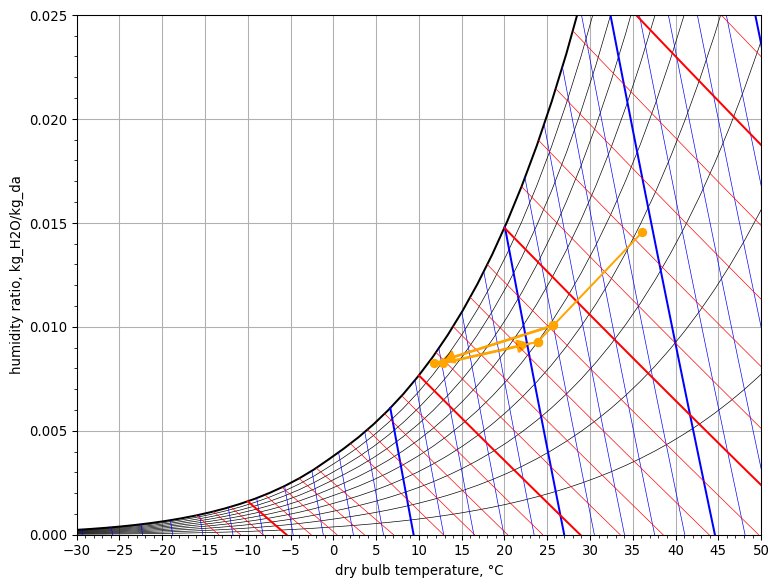

In [12]:
chart = PsychrometricChart(fig_size=(8, 6))
chart.plot_process(
    'mixing_chamber',
    StatePoint(vav_system.summer.outdoor_air.Tdb, vav_system.summer.outdoor_air.W),
    StatePoint(vav_system.summer.return_air.Tdb, vav_system.summer.return_air.W),
    StatePoint(vav_system.summer.mixed_air.Tdb, vav_system.summer.mixed_air.W)
)
chart.plot_process(
    'cooling coil',
    StatePoint(vav_system.summer.mixed_air.Tdb, vav_system.summer.mixed_air.W),
    StatePoint(vav_system.summer.cooled_air.Tdb, vav_system.summer.cooled_air.W)
)
# chart.plot_process(
#     'supply fan',
#     StatePoint(vav_system.summer.cooled_air.Tdb, vav_system.summer.cooled_air.W),
#     StatePoint(vav_system.summer.supply_air.Tdb, vav_system.summer.supply_air.W)
# )
chart.plot_process(
    'zones',
    StatePoint(vav_system.summer.supply_air.Tdb, vav_system.summer.supply_air.W),
    StatePoint(vav_system.summer.return_air.Tdb, vav_system.summer.return_air.W)
)
chart.show()

### Zone Info

The zones, instances of the `Zone` class, are kept in a list inside the `VAVSystem` class. A `Zone` object has two members `summer` and `winter` that refer to an instance of the `Season` dataclass that contains the design data for the zone. From the implementation of the `Season` dataclass, it can be seen which data attributes are available. Again the names of the data attributes should speak for themselves.

```
@dataclass
class Season:
    Q_sen: Quantity
    Q_lat: Quantity
    zone_air: HumidAir
    m_exhaust: Quantity = Q_(0.0, 'kg / s')
    m_supply: Optional[Quantity] = field(init=False, default=Q_(float('nan'), 'kg / s'))
    supply_air: Optional[HumidAir] = field(init=False, default=None)
    return_air: Optional[HumidAir] = field(init=False, default=None)

    @property
    def m_return(self) -> Quantity:
        return self.m_supply - self.m_exhaust

    @property
    def V_supply(self) -> Quantity:
        return self.m_supply * self.supply_air.v


@dataclass
class Zone:
    name: str
    summer: Optional[Season] = None
    winter: Optional[Season] = None
    reheat_coil: Optional[AirConditioningProcess] = field(init=False, default=None)
```



> **Notes**<br>
>- Attribute `m_exhaust` may refer to local air exhaust of a zone.<br>
>- To get at the resulting air state (in particular air humidity) of the zones, the `return_air` attribute should be used, as the `zone_air` attribute is actually used to specify the desired state when instantiating the zones.

In [13]:
ja.display_list([
    f"return air at {zone.name}: <b>{zone.summer.return_air.Tdb.to('degF'):~P.1f} TDB, "
    f"{zone.summer.return_air.RH.to('pct'):~P.0f} RH</b>, "
    f"supply air volume flow rate: <b>{zone.summer.V_supply.to('ft ** 3 / min'):~P.0f}</b>"
    for zone in vav_system.zones
])

## HEATING DESIGN DAY

In [14]:
winter_results = vav_system.design_winter(
    T_supply_max=Q_(105, 'degF'),
    supply_fan_pressure=Q_(3.0, 'inch_H2O_60F'),
    supply_fan_efficiency=Q_(60.0, 'pct')
)

In [15]:
ja.display_list(
    vav_system.show_results_markdown(
        winter_results, 
        units={
            'Q': ('Btu / hr', 0),
            'V': ('ft ** 3 / min', 0),
            'K': ('degF', 1)
        }
    )
)

In [16]:
ja.display_list([
    f"{zone.name}: supply air temperature = <b>{zone.winter.supply_air.Tdb.to('degF'):~P.1f}</b>, "
    f"reheat load = <b>{zone.reheat_coil.Q_sen.to('Btu / hr'):~P.0f}</b>, "
    f"supply air volume flow rate = <b>{zone.winter.V_supply.to('ft ** 3 / min'):~P.0f}</b>"
    for zone in vav_system.zones
])